In [25]:
import random
import numpy as np
import tensorflow as tf

SEED = 42 

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Folder: Closed
Number of images: 660


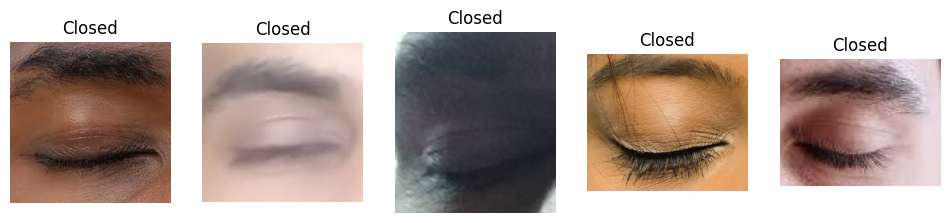

⚠️ Images in Closed are of different sizes

Folder: Open
Number of images: 663


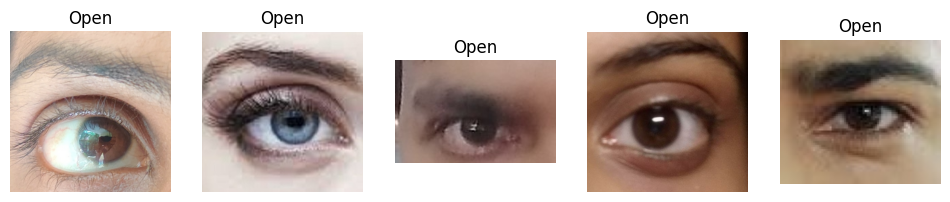

⚠️ Images in Open are of different sizes

Folder: yawn
Number of images: 723


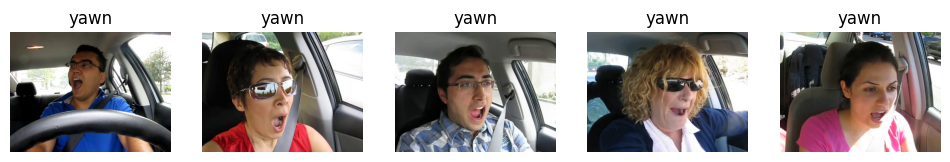

✅ All images in yawn are of the same size: (480, 640)

Folder: no_yawn
Number of images: 725


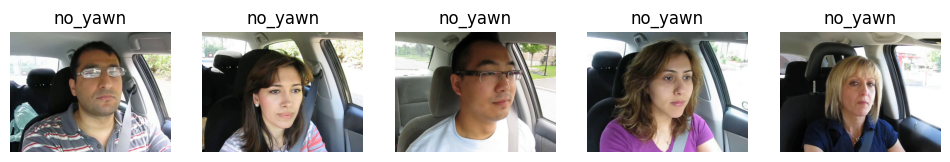

✅ All images in no_yawn are of the same size: (480, 640)


In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


# dataset path
data_dir = '/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train'

# folders inside train
folders = ['Closed', 'Open', 'yawn', 'no_yawn']

# dictionary to store counts
image_counts = {}

# loop through folders
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    images = os.listdir(folder_path)
    image_counts[folder] = len(images)
    
    print(f"\nFolder: {folder}")
    print(f"Number of images: {len(images)}")
    
    # plot 5 sample images
    plt.figure(figsize=(12, 6))
    for i, img_name in enumerate(images[:5]):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(folder)
    plt.show()
    
    # check image sizes
    sizes = set()
    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            sizes.add(img.shape[:2])  # (height, width)
    
    if len(sizes) == 1:
        print(f"✅ All images in {folder} are of the same size: {list(sizes)[0]}")
    else:
        print(f"⚠️ Images in {folder} are of different sizes")


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import seaborn as sns
import pathlib

# -------------------------
# User config / hyperparams
# -------------------------
data_dir = '/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train'  # CHANGE if needed
TARGET_CLASSES = ['yawn', 'no_yawn']
IMG_SIZE = (224, 224)        # fixed size for both custom and transfer models
BATCH_SIZE = 32
SEED = 42
EPOCHS_CUSTOM = 50
EPOCHS_TL = 20
LEARNING_RATE = 1e-3


In [28]:
# -------------------------
# Verify dataset & counts
# -------------------------
for c in TARGET_CLASSES:
    p = os.path.join(data_dir, c)
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Expected directory for class '{c}' at: {p}")
    count = len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p, f))])
    print(f"Class '{c}': {count} images")



Class 'yawn': 723 images
Class 'no_yawn': 725 images


Found 1448 files belonging to 2 classes.
Using 1014 files for training.
Found 1448 files belonging to 2 classes.
Using 434 files for validation.
Class names (inferred): ['yawn', 'no_yawn']

Dataset sizes (batches):
Train: 32
Val: 7
Test: 7


/tmp/ipykernel_36/2277039893.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # float→int


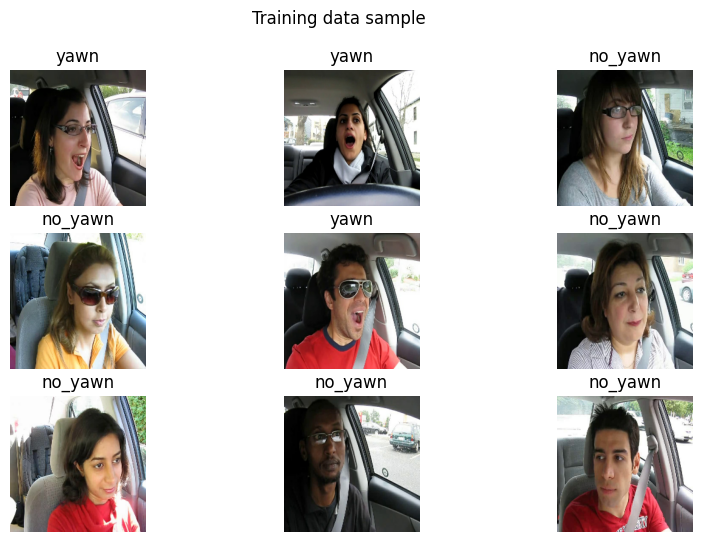

In [29]:
# 1. Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=["yawn", "no_yawn"],
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,   # 70% train, 30% val+test
    subset="training",
    seed=SEED
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    class_names=["yawn", "no_yawn"],
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=SEED
)

# 2. Save class names BEFORE caching/prefetch
class_names = train_ds.class_names
print("Class names (inferred):", class_names)

# 3. Split val_test_ds into val/test
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

print("\nDataset sizes (batches):")
print("Train:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test:", tf.data.experimental.cardinality(test_ds).numpy())

# 4. Now apply cache/prefetch (after saving class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# -------------------------
# Optional: visualize some samples
# -------------------------
def show_batch(dataset, title="Sample images"):
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = int(labels[i].numpy())  # float→int
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Training data sample")


In [30]:
# -------------------------
# Data augmentation + preprocessing layers
# -------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.06),
], name="data_augmentation")

# Normalization layer (rescale pixels 0-1)
rescale = layers.Rescaling(1./255)

In [31]:
# -------------------------
# Build Custom CNN (from scratch)  --> (3,) is for 3 channels
# GlobalAveragePooling2D() and GlobalMaxPooling2D() convert 2D feature maps into 1D feature vectors, so no need of flattern layer .
# -------------------------

def build_custom_cnn(input_shape=IMG_SIZE + (3,)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = rescale(x)
    # Conv block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    # Conv block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    # Conv block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # binary
    model = keras.Model(inputs, outputs, name='custom_cnn')
    return model

In [32]:
custom_model = build_custom_cnn()
custom_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
custom_model.summary()

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [33]:
# print(train_ds.shape)
print(type(train_ds))
print(train_ds)

# print(val_ds.shape)
print(type(val_ds))
print(val_ds)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [34]:

# -------------------------
# Train the Custom CNN
# -------------------------
callbacks = [
    keras.callbacks.ModelCheckpoint("custom_cnn_best.h5", save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history_custom = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_CUSTOM,
    callbacks=callbacks
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.5588 - loss: 0.6907 - val_accuracy: 0.4955 - val_loss: 0.6940
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6200 - loss: 0.6098 - val_accuracy: 0.4955 - val_loss: 0.7132
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.6361 - loss: 0.6056 - val_accuracy: 0.4955 - val_loss: 0.8112
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.6431 - loss: 0.5959 - val_accuracy: 0.4955 - val_loss: 1.1575
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.6759 - loss: 0.5814 - val_accuracy: 0.4955 - val_loss: 0.8122
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.6617 - loss: 0.5682 - val_accuracy: 0.4955 - val_loss: 0.9494


In [42]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [35]:
# Build y_true and y_pred arrays for confusion matrix & classification report
def get_labels_and_predictions(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset.unbatch().batch(256):  # manageable chunks
        preds = model.predict(images, verbose=0).ravel()
        y_pred.extend((preds >= 0.5).astype(int).tolist())
        y_true.extend(labels.numpy().astype(int).tolist())
    return np.array(y_true), np.array(y_pred)


# Plot training curves for custom model
def plot_history(history, title_prefix=""):
    history_dict = history.history
    epochs_range = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(12, 4))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history_dict['loss'], label='train_loss')
    plt.plot(epochs_range, history_dict['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history_dict['accuracy'], label='train_acc')
    plt.plot(epochs_range, history_dict['val_accuracy'], label='val_acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4496 - loss: 0.6989

Custom CNN Test Loss: 0.6995, Test Accuracy: 0.4476

Custom CNN - Classification Report:

              precision    recall  f1-score   support

        yawn       0.45      1.00      0.62        94
     no_yawn       0.00      0.00      0.00       116

    accuracy                           0.45       210
   macro avg       0.22      0.50      0.31       210
weighted avg       0.20      0.45      0.28       210



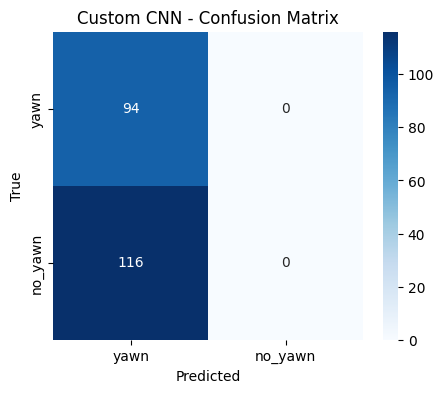

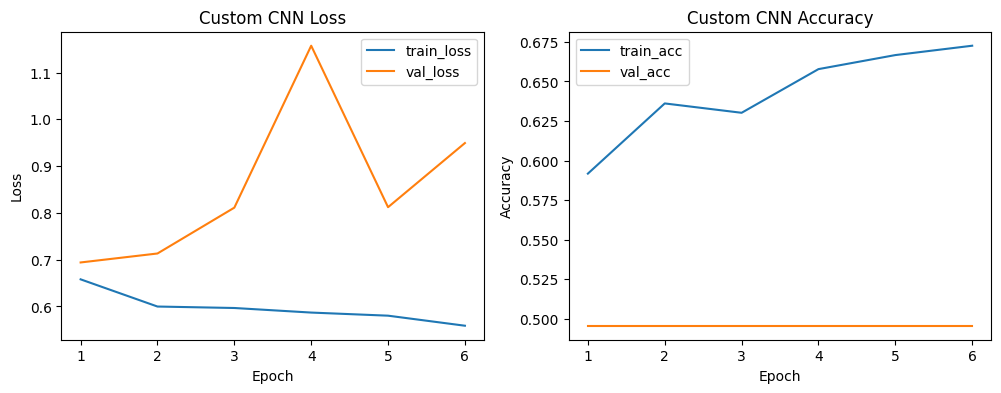

In [36]:
# -------------------------
# Evaluate on test set & metrics (Custom CNN)
# -------------------------
test_loss, test_acc = custom_model.evaluate(test_ds)
print(f"\nCustom CNN Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



y_true_c, y_pred_c = get_labels_and_predictions(custom_model, test_ds)

# Confusion matrix & classification report
cm_c = confusion_matrix(y_true_c, y_pred_c)
print("\nCustom CNN - Classification Report:\n")
print(classification_report(y_true_c, y_pred_c, target_names=class_names,zero_division=0))



# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_c, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Custom CNN - Confusion Matrix')
plt.show()

plot_history(history_custom, title_prefix="Custom CNN")

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

# ✅ Grad-CAM heatmap function for custom CNN
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute pooled grads
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight conv outputs with grads
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ✅ Overlay heatmap on image
def overlay_gradcam(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Ensure image is uint8
    if img.dtype != np.uint8:
        img = np.uint8(255 * img / np.max(img))

    # Resize heatmap to match input image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # convert from BGR → RGB

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return superimposed_img


def show_gradcam_samples(dataset, class_names, model, last_conv_layer_name, num_images=3):
    plt.figure(figsize=(12, 6))
    count = 0
    for images, labels in dataset.take(1):  # take 1 batch
        for i in range(min(num_images, images.shape[0])):
            img = images[i].numpy().astype("uint8")
            label = int(labels[i].numpy())  # ✅ cast to int

            img_array = np.expand_dims(images[i], axis=0)
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
            superimposed_img = overlay_gradcam(img, heatmap)

            # Show original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(img)
            plt.title(f"True: {class_names[label]}")
            plt.axis("off")

            # Show GradCAM
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(superimposed_img)
            plt.title("GradCAM")
            plt.axis("off")

            count += 1
        break  # only take one batch
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_36/1847319493.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())  # ✅ cast to int
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_37']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


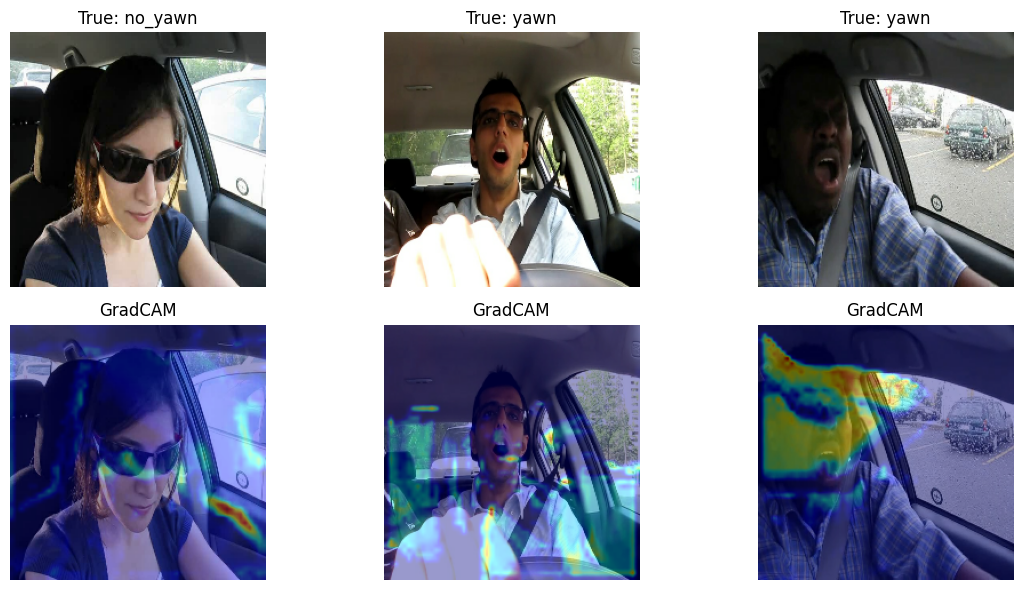

In [38]:
last_conv_layer_name = "conv2d_8"  # adjust if different in summary
show_gradcam_samples(test_ds, class_names, custom_model, last_conv_layer_name)


## **Use CBAM Block to improve performance** 

In [39]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# -------------------------
# CBAM block

# Channel Attention:
# Used both Global Average Pooling and Global Max Pooling.
# Passed both through a shared MLP with two dense layers:
# First layer units: channel // ratio
# Second layer units: channel
# Added the outputs and passed through a sigmoid.
# Reshaped and multiplied with the input feature.

# Spatial Attention:
# Computed average and max pooling along channel axis.
# Concatenated both.
# Used a 7x7 Conv2D with sigmoid activation.
# Multiplied attention map with input.

# -------------------------

def cbam_block(input_feature, ratio=8):
    """Convolutional Block Attention Module (CBAM)"""

    channel = input_feature.shape[-1]

    # -------- Channel Attention --------
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)

    # Shared MLP
    shared_dense_1 = layers.Dense(channel // ratio, activation='relu') # ( 2 layers first contains c/r unit)
    shared_dense_2 = layers.Dense(channel)                             # (second layer contains c unit)

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, channel))(channel_attention)

    x = layers.Multiply()([input_feature, channel_attention])

    # -------- Spatial Attention --------
    avg_pool_spatial = layers.Lambda(lambda t: K.mean(t, axis=-1, keepdims=True))(x)
    max_pool_spatial = layers.Lambda(lambda t: K.max(t, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spatial_attention])

    return x

# -------------------------
# Build Custom CNN with CBAM
# -------------------------
def build_custom_cnn_cbam(input_shape=(224,224,3)):
    inputs = keras.Input(shape=input_shape)
    # Example: data augmentation and rescale can be added externally if needed
    # x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(inputs)  # simple rescale

    # ----- Conv Block 1 -----
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 2 -----
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    # ----- Conv Block 3 -----
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # binary classification

    model = keras.Model(inputs, outputs, name='custom_cnn_cbam')
    return model

# -------------------------
# Compile model
# -------------------------
LEARNING_RATE = 1e-3
IMG_SIZE = (224, 224)

custom_model_cbam = build_custom_cnn_cbam(input_shape=IMG_SIZE + (3,))
custom_model_cbam.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

custom_model_cbam.summary()


Model: "custom_cnn_cbam"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │        896 │ rescaling_2[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 4)         │        132 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │        160 │ dense_6[0][0],    │
│                     │                   │            │ dense_6[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32)        │          0 │ dense_7[0][0],    │
│                     │                   │            │ dense_7[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32)        │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 224, 224,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ lambda[0][0],     │
│ (Concatenate)       │ 2)                │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 224, 224,  │         99 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 224, 224,  │          0 │ multiply[0][0],   │
│ (Multiply)          │ 32)               │            │ conv2d_10[0][0] 

 Total params: 116,710 (455.90 KB)

 Trainable params: 116,262 (454.15 KB)

 Non-trainable params: 448 (1.75 KB)

In [40]:
# -------------------------
# Callbacks
# -------------------------
callbacks_cbam = [
    keras.callbacks.ModelCheckpoint("custom_cnn_cbam_best.h5", 
                                    save_best_only=True, 
                                    monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  patience=5, 
                                  restore_best_weights=True)
]

# -------------------------
# Train CBAM CNN
# -------------------------
history_cbam = custom_model_cbam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_CUSTOM,  # same as your previous CNN
    callbacks=callbacks_cbam
)


Epoch 1/20


I0000 00:00:1758562952.334774     110 service.cc:148] XLA service 0x3c882ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758562952.337706     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758562952.337729     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5234 - loss: 0.6965 

I0000 00:00:1758562962.074401     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 453ms/step - accuracy: 0.5795 - loss: 0.6712 - val_accuracy: 0.5045 - val_loss: 0.6931
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.6900 - loss: 0.5664 - val_accuracy: 0.5045 - val_loss: 0.6931
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8206 - loss: 0.4071 - val_accuracy: 0.5045 - val_loss: 0.6931
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8887 - loss: 0.2935 - val_accuracy: 0.5045 - val_loss: 0.6934
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9115 - loss: 0.2293 - val_accuracy: 0.5045 - val_loss: 0.6948
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9598 - loss: 0.1335 - val_accuracy: 0.5045 - val_loss: 0.6981
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9647 - loss: 0.0908 - val_accuracy: 0.5045 - val_loss: 0.6987
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9578 - loss: 0.1218 - val_accuracy: 0.5045 - val_loss: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.5504 - loss: 0.6915

Custom CNN + CBAM Test Loss: 0.6915, Test Accuracy: 0.5524

Custom CNN + CBAM - Classification Report:

              precision    recall  f1-score   support

        yawn       0.00      0.00      0.00        94
     no_yawn       0.55      1.00      0.71       116

    accuracy                           0.55       210
   macro avg       0.28      0.50      0.36       210
weighted avg       0.31      0.55      0.39       210



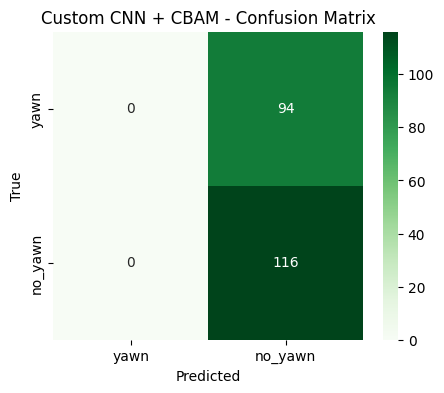

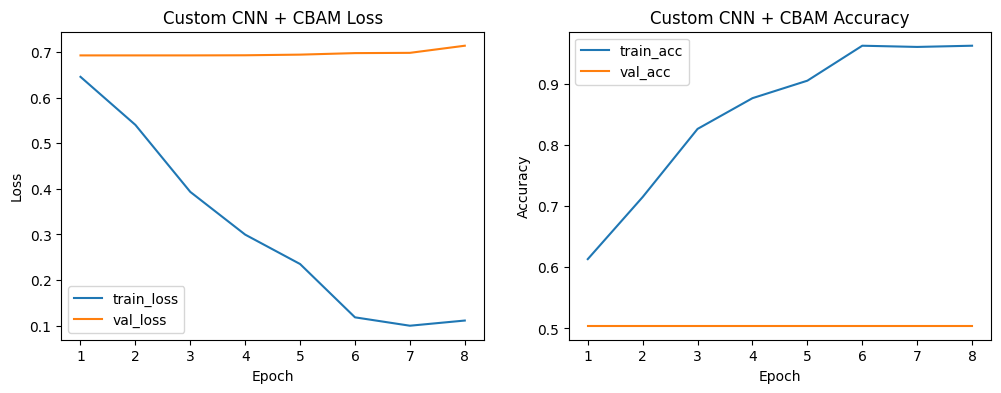

In [41]:

# -------------------------
# Evaluate on test set
# -------------------------
test_loss_cbam, test_acc_cbam = custom_model_cbam.evaluate(test_ds)
print(f"\nCustom CNN + CBAM Test Loss: {test_loss_cbam:.4f}, Test Accuracy: {test_acc_cbam:.4f}")

# -------------------------
# Get true labels and predictions
# -------------------------
y_true_cbam, y_pred_cbam = get_labels_and_predictions(custom_model_cbam, test_ds)

# -------------------------
# Confusion matrix & classification report
# -------------------------
cm_cbam = confusion_matrix(y_true_cbam, y_pred_cbam)
print("\nCustom CNN + CBAM - Classification Report:\n")
print(classification_report(y_true_cbam, y_pred_cbam, target_names=class_names, zero_division=0))

# -------------------------
# Plot confusion matrix
# -------------------------
plt.figure(figsize=(5,4))
sns.heatmap(cm_cbam, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Custom CNN + CBAM - Confusion Matrix')
plt.show()

# -------------------------
# Plot training history (accuracy & loss)
# -------------------------
plot_history(history_cbam, title_prefix="Custom CNN + CBAM")


## **CBAM with MAR(Mouth Aspect Ratio)**

In [143]:
!pip install mediapipe --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 49.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
pandas-gbq 0.29.1 requires google-api-core<3.0.0,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-storage 2.19.0 requires google-api-core<3.0.0dev,>=2.15.0, but you have google-api-core 1.34.1 which is incompatible.
dataproc-spark-connect 0.7.5 requires google-api-core>=2.19, but you have google-api-core 1.34.1 which is incompatible.
bigfra

In [144]:
import mediapipe as mp
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# -------------------------
# Settings
# -------------------------
IMG_SIZE = (224, 224)
LEARNING_RATE = 1e-4
EPOCHS_CUSTOM = 25
BATCH_SIZE = 32

# Dataset path
data_dir = '/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train'


mp_face_mesh = mp.solutions.face_mesh

# Indices for lips (from Mediapipe Face Mesh)
UPPER_LIP = [13, 14, 15, 16, 17]
LOWER_LIP = [78, 308, 82, 312, 13]  # just examples; can adjust

def compute_mar(image):
    """
    Compute Mouth Aspect Ratio (MAR) from an image using Mediapipe Face Mesh
    """
    with mp_face_mesh.FaceMesh(static_image_mode=True) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        if not results.multi_face_landmarks:
            return None  # no face detected
        
        landmarks = results.multi_face_landmarks[0].landmark
        # Get y-coordinates of upper and lower lip
        upper_y = np.mean([landmarks[i].y for i in UPPER_LIP])
        lower_y = np.mean([landmarks[i].y for i in LOWER_LIP])
        mar = lower_y - upper_y  # simple vertical distance
        return mar


def preprocess_with_mar(image, label):
    # Resize image
    image_resized = tf.image.resize(image, IMG_SIZE)
    image_resized = image_resized / 255.0

    # Convert to numpy for MAR computation
    img_np = image_resized.numpy()
    img_np = (img_np * 255).astype(np.uint8)

    # Compute MAR
    mar = compute_mar(img_np)
    if mar is None:
        mar = 0.0  # if face not detected

    mar = np.array([mar], dtype=np.float32)
    return image_resized, mar, label


In [145]:
def build_cnn_mar(input_shape=IMG_SIZE + (3,)):
    # Image input
    img_input = keras.Input(shape=input_shape, name='image_input')
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)  # CNN features

    # MAR input
    mar_input = keras.Input(shape=(1,), name='mar_input')

    # Concatenate CNN features with MAR
    combined = layers.Concatenate()([x, mar_input])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.4)(combined)
    output = layers.Dense(1, activation='sigmoid')(combined)

    model = keras.Model(inputs=[img_input, mar_input], outputs=output)
    return model


cnn_mar_model = build_cnn_mar()
cnn_mar_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



cnn_mar_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 224, 224,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mar_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 129)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ mar_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │     16,640 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 1)         │        129 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,913 (433.25 KB)

 Trainable params: 110,465 (431.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [147]:
# -------------------------
# Imports
# -------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import mediapipe as mp

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4

# -------------------------
# CBAM block
# -------------------------
def cbam_block(input_feature, ratio=8):
    # Channel Attention
    channel = input_feature.shape[-1]
    avg_pool = tf.reduce_mean(input_feature, axis=[1,2], keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=[1,2], keepdims=True)

    shared_dense = keras.Sequential([
        layers.Dense(channel//ratio, activation='relu'),
        layers.Dense(channel)
    ])

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    channel_attention = tf.nn.sigmoid(avg_out + max_out)
    x = input_feature * channel_attention

    # Spatial Attention
    avg_pool_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_pool_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = tf.concat([avg_pool_spatial, max_pool_spatial], axis=-1)
    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = x * spatial_attention
    return x

# -------------------------
# Data Augmentation & Rescale
# -------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
rescale = layers.Rescaling(1./255)

# -------------------------
# Mediapipe FaceMesh (initialized once)
# -------------------------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def compute_mar_fixed(image):
    """
    Compute MAR using Mediapipe FaceMesh.
    Returns a float. If face not detected, returns 0.0
    """
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    if not results.multi_face_landmarks:
        return 0.0
    
    # Example indices for inner mouth landmarks (replace with actual MAR computation)
    landmarks = results.multi_face_landmarks[0].landmark
    top = np.array([landmarks[13].x, landmarks[13].y])
    bottom = np.array([landmarks[14].x, landmarks[14].y])
    left = np.array([landmarks[78].x, landmarks[78].y])
    right = np.array([landmarks[308].x, landmarks[308].y])
    
    vertical = np.linalg.norm(top - bottom)
    horizontal = np.linalg.norm(left - right)
    mar = vertical / horizontal if horizontal > 0 else 0.0
    return mar

def preprocess_with_mar_fixed(image_tensor, label):
    img_np = image_tensor.numpy().astype(np.uint8)
    img_resized = cv2.resize(img_np, IMG_SIZE)
    mar = compute_mar_fixed(img_resized)
    lbl = int(label.numpy())
    return img_resized, mar, lbl

def tf_preprocess_with_mar(image, label):
    img_resized, mar, lbl = tf.py_function(
        preprocess_with_mar_fixed,
        inp=[image, label],
        Tout=[tf.uint8, tf.float32, tf.int32]
    )
    img_resized.set_shape(IMG_SIZE + (3,))
    mar.set_shape(())
    lbl.set_shape(())
    return (img_resized, mar), lbl

# -------------------------
# Load dataset (example)
# -------------------------
# Only for 2 classes: "yawn" and "no_yawn"
data_dir = "/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train"
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42,
    class_names=["no_yawn", "yawn"]
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=42,
    class_names=["no_yawn", "yawn"]
)

# Apply MAR preprocessing
train_ds = train_ds.map(tf_preprocess_with_mar, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(tf_preprocess_with_mar, num_parallel_calls=AUTOTUNE)
test_ds = val_ds  # here we just reuse val_ds; replace with proper test_ds if available

# Prefetch for performance
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# -------------------------
# Custom CNN with CBAM + MAR
# -------------------------
def build_custom_cnn_cbam_mar(input_shape=IMG_SIZE + (3,)):
    img_input = keras.Input(shape=input_shape)
    mar_input = keras.Input(shape=(1,), name="mar_input")
    
    x = data_augmentation(img_input)
    x = rescale(x)
    
    # Conv Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)
    
    # Conv Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)
    
    # Conv Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    # Combine MAR input
    x = layers.Concatenate()([x, mar_input])
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[img_input, mar_input], outputs=outputs, name="custom_cnn_cbam_mar")
    return model

custom_model_cbam_mar = build_custom_cnn_cbam_mar()
custom_model_cbam_mar.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
custom_model_cbam_mar.summary()

# -------------------------
# Train
# -------------------------
callbacks = [
    keras.callbacks.ModelCheckpoint("custom_cnn_cbam_mar_best.h5", save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = custom_model_cbam_mar.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

# -------------------------
# Evaluate
# -------------------------
test_loss, test_acc = custom_model_cbam_mar.evaluate(test_ds)
print(f"\nCustom CNN + CBAM + MAR Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# -------------------------
# Helper: get predictions for metrics
# -------------------------
def get_labels_and_predictions(model, dataset):
    y_true, y_pred = [], []
    for (images, mars), labels in dataset:
        preds = model.predict([images, tf.expand_dims(mars, axis=-1)], verbose=0)
        preds = (preds > 0.5).astype(int)
        y_pred.extend(preds.flatten().tolist())
        y_true.extend(labels.numpy().tolist())
    return y_true, y_pred

y_true, y_pred = get_labels_and_predictions(custom_model_cbam_mar, test_ds)

# Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["no_yawn", "yawn"], zero_division=0))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["no_yawn", "yawn"], yticklabels=["no_yawn", "yawn"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


RuntimeError: ValidatedGraphConfig Initialization failed.
ConstantSidePacketCalculator: ; RET_CHECK failure (mediapipe/calculators/core/constant_side_packet_calculator.cc:66) (cc->OutputSidePackets().NumEntries(kPacketTag))==(options.packet_size())Number of output side packets has to be same as number of packets configured in options.
ConstantSidePacketCalculator: ; RET_CHECK failure (mediapipe/calculators/core/constant_side_packet_calculator.cc:66) (cc->OutputSidePackets().NumEntries(kPacketTag))==(options.packet_size())Number of output side packets has to be same as number of packets configured in options.
ImageToTensorCalculator: ; RET_CHECK failure (mediapipe/calculators/tensor/image_to_tensor_calculator.cc:155) ValidateOptionOutputDims(options) returned INTERNAL: ; RET_CHECK failure (./mediapipe/calculators/tensor/image_to_tensor_utils.h:136) options.has_output_tensor_float_range() || options.has_output_tensor_int_range() || options.has_output_tensor_uint_range()Output tensor range is required. 
SplitTensorVectorCalculator: The number of output streams should match the number of ranges specified in the CalculatorOptions.
SplitTensorVectorCalculator: The number of output streams should match the number of ranges specified in the CalculatorOptions.
SplitTensorVectorCalculator: The number of output streams should match the number of ranges specified in the CalculatorOptions.

In [ ]:

# -------------------------
# Callbacks
# -------------------------
callbacks = [
    keras.callbacks.ModelCheckpoint("cbam_mar_best.h5", save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# -------------------------
# Train
# -------------------------
history = model.fit(
    {"image_input": train_imgs, "mar_input": train_mars},
    train_labels,
    validation_data=({"image_input": val_imgs, "mar_input": val_mars}, val_labels),
    epochs=EPOCHS_CUSTOM,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

# -------------------------
# Evaluate
# -------------------------
test_loss, test_acc = model.evaluate({"image_input": test_imgs, "mar_input": test_mars}, test_labels)
print(f"\nCBAM+MAR Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


## **Transfer Learning with Mobilenet V2**

In [43]:
# -------------------------
# Transfer Learning approach (MobileNetV2)
# -------------------------
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

def build_tl_model(base_trainable=False, input_shape=IMG_SIZE + (3,)):
    # Input + augmentation
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Use MobileNetV2 preprocessing (scales to [-1,1])
    x = layers.Lambda(mobilenet_preprocess)(x)
    base = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    base.trainable = base_trainable
    x = base(x, training=False)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name='mobilenetv2_tl')
    return model

In [44]:
# Build with base frozen
tl_model = build_tl_model(base_trainable=False)
tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
tl_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_tl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [45]:
# Train top head first
callbacks_tl = [
    keras.callbacks.ModelCheckpoint("tl_top_best.h5", save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

history_tl_top = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TL,
    callbacks=callbacks_tl
)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.4868 - loss: 0.7650 - val_accuracy: 0.5893 - val_loss: 0.6063
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6572 - loss: 0.6174 - val_accuracy: 0.6607 - val_loss: 0.5776
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6739 - loss: 0.5778 - val_accuracy: 0.6652 - val_loss: 0.5686
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6782 - loss: 0.5700 - val_accuracy: 0.6875 - val_loss: 0.5510
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6901 - loss: 0.5426 - val_accuracy: 0.7054 - val_loss: 0.5433
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7215 - loss: 0.5206 - val_accuracy: 0.7054 - val_loss: 0.5378
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7099 - loss: 0.5256 - val_accuracy: 0.7054 - val_loss: 0.5369
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7628 - loss: 0.4800 - val_accuracy: 0.6875 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7852 - loss: 0.4587

TL (top only) Test Loss: 0.4777, Test Accuracy: 0.7714

TL (top only) - Classification Report:

              precision    recall  f1-score   support

        yawn       0.98      0.50      0.66        94
     no_yawn       0.71      0.99      0.83       116

    accuracy                           0.77       210
   macro avg       0.84      0.75      0.74       210
weighted avg       0.83      0.77      0.75       210



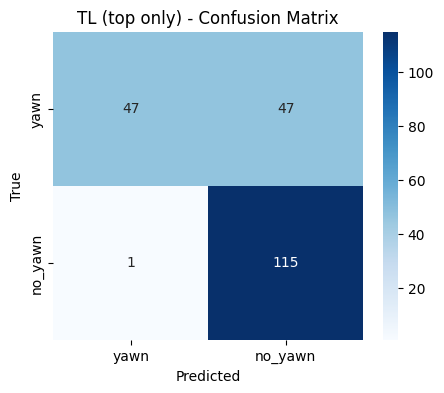

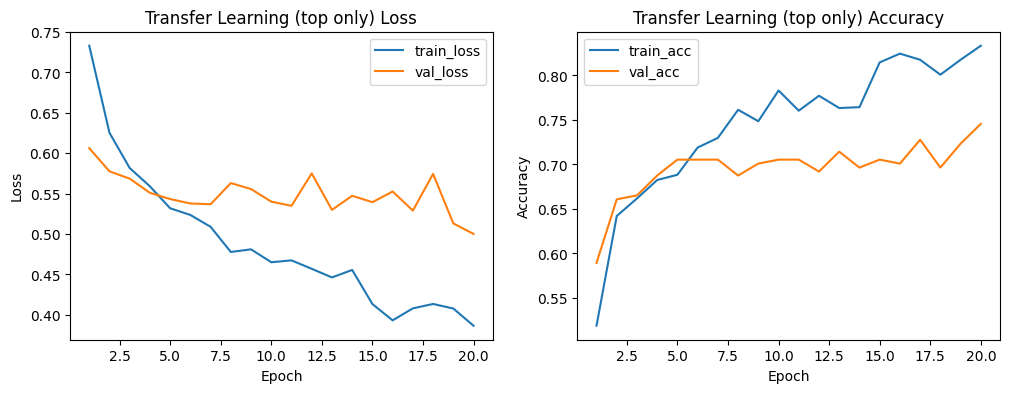

In [46]:
# Evaluate the transfer model (base frozen)
test_loss_tl, test_acc_tl = tl_model.evaluate(test_ds)
print(f"\nTL (top only) Test Loss: {test_loss_tl:.4f}, Test Accuracy: {test_acc_tl:.4f}")

y_true_t, y_pred_t = get_labels_and_predictions(tl_model, test_ds)
cm_t = confusion_matrix(y_true_t, y_pred_t)
print("\nTL (top only) - Classification Report:\n")
print(classification_report(y_true_t, y_pred_t, target_names=class_names))

plt.figure(figsize=(5,4))
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('TL (top only) - Confusion Matrix')
plt.show()

plot_history(history_tl_top, title_prefix="Transfer Learning (top only)")

## **FineTune some Top layers of Base Model**

In [ ]:
# -------------------------
# Optional: Fine-tune some top layers of base model
# -------------------------
# Unfreeze last few layers of the base model and fine-tune

base_model = tl_model.get_layer(index=3)  # MobileNetV2 base (index may vary); safer to find by name
print("\nBase model found:", base_model.name)
# Set trainable layers (unfreeze last n layers)
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last N layers for fine-tuning
UNFREEZE_AT = -10  # unfreeze the last 10 layers; tune as needed
if UNFREEZE_AT < 0:
    for layer in base_model.layers[UNFREEZE_AT:]:
        layer.trainable = True

# Recompile with lower LR
tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [96]:
# Fine-tune training
history_tl_finetune = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TL,
    callbacks=[
        keras.callbacks.ModelCheckpoint("tl_finetune_best.h5", save_best_only=True, monitor='val_accuracy'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8438 - loss: 0.4220 - val_accuracy: 0.5804 - val_loss: 0.6545
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9062 - loss: 0.3382 - val_accuracy: 0.5848 - val_loss: 0.6544
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9062 - loss: 0.3971 - val_accuracy: 0.5804 - val_loss: 0.6543
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.2726 - val_accuracy: 0.5848 - val_loss: 0.6543
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8125 - loss: 0.3572 - val_accuracy: 0.5848 - val_loss: 0.6543
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9062 - loss: 0.3373 - val_accuracy: 0.5938 - val_loss: 0.6543
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8438 - loss: 0.3880 - val_accuracy: 0.5982 - val_loss: 0.6543
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9375 - loss: 0.3431 - val_accuracy: 0.6027 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5961 - loss: 0.7071

TL (fine-tuned) Test Loss: 0.6978, Test Accuracy: 0.5952

TL (fine-tuned) - Classification Report:

              precision    recall  f1-score   support

        yawn       0.54      0.63      0.58        94
     no_yawn       0.65      0.57      0.61       116

    accuracy                           0.60       210
   macro avg       0.60      0.60      0.59       210
weighted avg       0.60      0.60      0.60       210



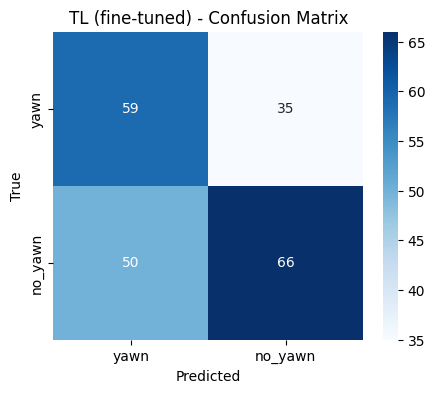

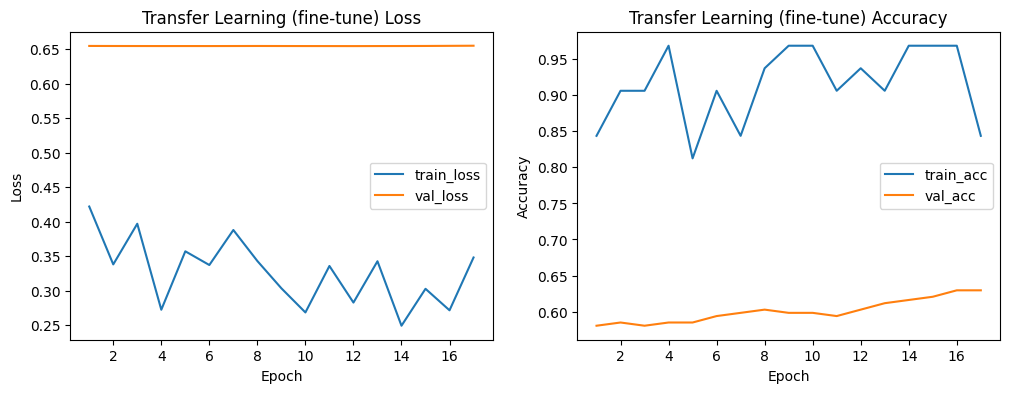

In [97]:
# Evaluate fine-tuned model
test_loss_tl_ft, test_acc_tl_ft = tl_model.evaluate(test_ds)
print(f"\nTL (fine-tuned) Test Loss: {test_loss_tl_ft:.4f}, Test Accuracy: {test_acc_tl_ft:.4f}")

y_true_tf, y_pred_tf = get_labels_and_predictions(tl_model, test_ds)
cm_tf = confusion_matrix(y_true_tf, y_pred_tf)
print("\nTL (fine-tuned) - Classification Report:\n")
print(classification_report(y_true_tf, y_pred_tf, target_names=class_names))

plt.figure(figsize=(5,4))
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('TL (fine-tuned) - Confusion Matrix')
plt.show()

plot_history(history_tl_finetune, title_prefix="Transfer Learning (fine-tune)")

In [98]:
# -------------------------
# Final summary prints
# -------------------------
print("\n=== Final Results Summary ===")
print(f"Custom CNN -> Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")
print(f"TL (top only) -> Test accuracy: {test_acc_tl:.4f}, loss: {test_loss_tl:.4f}")
print(f"TL (fine-tuned) -> Test accuracy: {test_acc_tl_ft:.4f}, loss: {test_loss_tl_ft:.4f}")

# Optional: save models
custom_model.save("custom_cnn_model.h5")
tl_model.save("mobilenetv2_finetuned.h5")

print("\nSaved models: custom_cnn_model.h5 and mobilenetv2_finetuned.h5")


=== Final Results Summary ===
Custom CNN -> Test accuracy: 0.4476, loss: 0.6950
TL (top only) -> Test accuracy: 0.5810, loss: 0.6951
TL (fine-tuned) -> Test accuracy: 0.5952, loss: 0.6978

Saved models: custom_cnn_model.h5 and mobilenetv2_finetuned.h5
